In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import random
import pandas as pd
import glob, os
import fnmatch
from linfit import linfit
import matplotlib.pyplot as plt
import specmatchemp.library
import specmatchemp.plots as smplot
from scipy.integrate import trapz
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import CustomJS, Button
from bokeh.layouts import row, column
from fakescorr import fakescorr

#style stuff
from matplotlib import rc, rcParams
rc('text', usetex=True)
rc('font', size=13)
rc('legend', fontsize=13)
rcParams.update({'font.size':13})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('mathtext', fontset='stixsans')


#CAUTION: by hand parameters, not automated because of laziness:
excl = {'M44': 219.,'Pleiades':196.}
#TODO: Remove redundancies in trange
trange = {'M44': [
                   (3e3,7e3,'k', 5e28, 5e36),  
                   (3e3,3.249e3,'red', 5e28, 5e36),
                   (3.25e3,3.499e3,'orange', 5e28, 5e36),
                   (3.5e3,3.749e3,'green', 5e28, 5e36),
                   (3.75e3,4e3,'c', 5e28, 5e36),
                 ],
          'M67': [  (3e3,7e3,'k', 5e28, 5e36),      
                   (3e3,3.249e3,'red', 5e28, 5e36),
                   (3.25e3,3.499e3,'orange', 5e28, 5e36),
                   (3.5e3,3.749e3,'green', 5e28, 5e36),
                   (3.75e3,4e3,'c', 5e28, 5e36),],
     'Pleiades': [
                  (3e3,7e3,'k', 5e28, 5e36),
                  (3e3,3.249e3,'red', 5e28, 5e36),
                  (3.25e3,3.499e3,'orange', 5e28, 5e36),
                  (3.5e3,3.749e3,'green', 5e28, 5e36),
                  (3.75e3,4e3,'c', 5e28, 5e36),
                  ],}



def foldering(path):
    if os.path.exists(path)==False:
        os.mkdir(path)
    return

#-------------------------------
#FFD
#-------------------------------
def print_susp(specs, Tmin, Tmax,cluster, test,):
    select_suspicious = specs[(specs['T']>=Tmin) & (specs['T']<=Tmax)]
    for oid in select_suspicious.index.values:
        try:
            flux, flares = import_flares(cluster, test, oid)
        except FileNotFoundError:
            continue
        plt.figure(figsize=(10,2))
        plt.plot(flux.time,(flux.flux_gap-flux.flux_model))
        for i, row in flares.iterrows():
            plt.plot(flux.time.iloc[row.istart:row.istop],
                     (flux.flux_gap-flux.flux_model).iloc[row.istart:row.istop],
                     linewidth=2,
                     color='red',)
            plt.title(oid)
    return

def ED(start,stop,time,flux_model,flux_gap, error):
    
    '''
    Returns the equivalend duratio of a flare event,
    found within indices [start, stop],
    calculated as the area under the residual (flux_gap-flux_model)
    Returns also the error on ED following (Davenport 2016)
    
    Parameters:
    --------------
    start - start time index of a flare event
    stop - end time index of a flare event
    time - time array
    flux_model - model quiescent flux 
    flux_gap - long-term trend removed raw light curve
    error - rolling std error to raw flux
    
    Returns:
    --------------
    ed - equivalent duration in seconds
    ederr - uncertainty in seconds
    '''
    
    start, stop = int(start),int(stop)
    time = np.asarray(time)[start-1:stop+1]
    #model = pd.Series(np.asarray(flux_gap)[start:stop+1]).mean()
    model = np.asarray(flux_model)[start:stop+1]
    flux = np.asarray(flux_gap)[start:stop+1]
    error = np.asarray(error)[start:stop+1]
    residual = (flux - model)
    x = time*60.*60.*24.
    fx = residual/model
    ed = sum([(x[i]-x[i-1])*fx[i-1] for i in range(1,len(x))])
    #ed = trapz(residual/model,time*60.*60.*24.)
    #measure error on ED
    
    flare_chisq = chisq(flux, error, model)
    ederr = np.sqrt(ed**2 / (stop-start) / flare_chisq)
    return ed, ederr, flare_chisq

def chisq(data, error, model):
    '''
    Compute the normalized chi square statistic:
    chisq =  1 / N * SUM(i) ( (data(i) - model(i))/error(i) )^2
    '''
    return np.sum( ((data - model) / error)**2.0 ) / np.size(data)


def import_flares(cluster, test, oid):
    
    oid = int(float(oid))
    
    loc = 'stars_shortlist/{}/results/{}/results'.format(cluster,test)
    flux = pd.read_csv('{}/{}_flux.csv'.format(loc,oid))#, names= ['time','flux_gap','error','flux_model'])
    flares = pd.read_csv('{}/{}_flares.csv'.format(loc,oid))#, names= ['istart','istop'])

    return flux, flares

def write_flares(forf,cluster, test, EPIC, typ='flares',extra=''):
    
    '''
    Writes a data frame with flares or flux 
    for a certain light curve with EPIC ID from a cluster
    analysed during a certain test.
    
    Parameter:
    ------------
    
    Returns:
    ------------
    '''
    
    loc = 'stars_shortlist/{}/results/{}'.format(cluster,test)
    if typ == 'flares':
        forf.to_csv('{}/{}_flares{}.csv'.format(loc,EPIC,extra))
    elif typ == 'flux':
        forf.to_csv('{}/{}_flux.csv'.format(loc,EPIC))
    return 


DM = lambda x: 5.*np.log10(float(x))-5. 

def color_outlier_red(val,outliers):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    if outliers.empty: outliers=[]
    color=[]
    for id_ in val:
        if id_ in list(outliers):
            color.append('red')
        else:
            color.append('black')
    return color



def energy(oid_list, cluster, test, C, LCtype, specs, Tmin, Tmax, fakes=False,onlyenergy=False):
    corr, edtrue = [], []
    durfactor = []
    listnames = ['clusterenergy','clusterenergy_err',
                 'L','Lerr',
                 'clustered','clusterederr',
                 'Teff','EPIC',
                 'istart','istop']
    tlistnames = ['tenergy','tenergy_err',
                      'tmyed',
                      'tL','tLErr']
    for name in listnames:
        vars()[name] = []
            
    for i, oid in enumerate(oid_list):
   
        for name in tlistnames:
            vars()[name] = []
        
        try:
            flux, flares = import_flares(cluster, test, oid)
        except FileNotFoundError:
            
            continue
            
        specline = specs.loc[str(oid)]
        L_bol = specline['L_quiet_bol']
        L_bol_err = specline['L_quiet_bol_err']
        L_quiet = specline['L_quiet']
        L_quiet_err = specline['L_quiet_err']
        teff =  specline['T']
        if flares.empty:
            
            continue
        else:
            s_s = flares.dropna(how='any',subset=['istart_no_sys_no_thruster','istop_no_sys_no_thruster'])
            s_s['corrected'] = 1    
            
            
            for i,row in s_s.iterrows():
                ed, ederr, chi2 = ED(row['istart_no_sys_no_thruster'],
                               row['istop_no_sys_no_thruster'],
                               flux.time,flux.flux_model,flux.flux_gap, flux.error)
                energy_err = energyerr(ed, ederr, L_quiet, L_quiet_err)
          
                if (ed != 'nan') & (ed > 0):
                    results = [ed*L_quiet, energy_err,
                              L_bol,L_bol_err,
                              ed,ederr,
                              teff,oid,
                              row.istart,row.istop]
                    for (name,result) in zip(listnames,results):
                        vars()[name].append(result)
                    for (name,result) in zip(tlistnames,results[:5]):
                        vars()[name].append(result)

                    
                else:

                    for name in listnames+tlistnames:
                        vars()[name].append(np.nan)
        keys = ['myenerg','myenerg_err','L_bol','L_bol_err','myed']
        for (key,name) in zip(keys,tlistnames):
            s_s[key] = vars()[name]

        if (fakes==True) & (onlyenergy==False): 

            s_s = fakescorr(s_s, oid, C, cluster, test, LCtype)
            s_s['energ_true'] = s_s.ED_true*L_quiet
   
        if (fakes==True) & (onlyenergy==True): 

            s_s = fakescorr(s_s, oid, C, cluster, test, LCtype)
            s_s['energ_true'] = s_s.ED_true*L_quiet
            s_s['count_true'] = 1

        elif (fakes==False) & (onlyenergy==False): 
            
            s_s['count_true'] = 1
            s_s['energ_true'] = s_s['myenerg']
            
        corr.append(list(s_s.count_true))
        edtrue.append(list(s_s.energ_true))
        
        #helper to get rid of extra columns from I/O
        filtered = fnmatch.filter(s_s.columns.values, 'Unnamed:*')
        s_s = s_s.drop(filtered,axis=1)
        
        write_flares(s_s, cluster, test, oid, typ='flares') 
    
    #unpack list of lists
    corr = [i for item in corr for i in item]
    edtrue = [i for item in edtrue for i in item]
    
    d = dict()
    dfnames = ['clusterenergy','clusterenergy_err',
               'L_bol','L_bol_err',
               'clustered','clusterederr',
               'Teff','EPIC',
               'istart','istop']
    for (dfname,name) in zip(dfnames,listnames):
        d[dfname] = vars()[name]
    d['stars_in_bin'] = len(oid_list)
    d['Tmin'] = Tmin
    d['Tmax'] = Tmax
    d['count_true'] = corr
    d['energ_true'] = edtrue
    df = pd.DataFrame(d)
    try:
        artifacts = pd.read_csv('stars_shortlist/share/High_Energy_Flares/DropHighEnergy.csv',
                                usecols=['EPIC','istart','istop','checkTPFifflare'])
        a = artifacts[(artifacts.checkTPFifflare == 0) & (artifacts.EPIC.isin(oid_list))]
        df_clean = df[(~df.istop.isin(a.istop)) & (~df.istart.isin(a.istart))]
    except FileNotFoundError:
        print('No artifacts found.')
        df_clean = df
        pass
    print('Before removing high-energy artifacts: {}\nAfter removing high-energy artifacts: {}'.format(df.shape[0],
                                                                                                      df_clean.shape[0]))
    return df_clean

def energyerr(ed, ederr, L_quiet, L_quiet_err):
    #np.sqrt((ed * L_quiet_err)**2 + (ederr * L_quiet)**2) #in case I want to do it quadratically
    return (ed * L_quiet_err) + (ederr * L_quiet)




## Load parameters and calculate quiescent luminosity, assign spectral class and  if not already

In [23]:
cluster_dict = {'M67':['M67','M67', 15, 4.0, 850],
                #'Ruprecht_147':['Ruprecht 147','Ruprecht_147', 30, 2.5, 300.],
                'M44':['M44','M44', 47, 0.73, 181.5],
                #'M45':['M45','M45',55.,0.12,120.],
                'NGC_1647':['NGC 1647','NGC_1647',0.,0.145,550.],
                'Pleiades':['Pleiades','Pleiades',0.,0.120,136.]
               }

cluster ='Pleiades'
basics = cluster_dict[cluster]
test = 'run_06'
C = '04'
LCtype = 'k2sc'
dm = DM(basics[4])
global dm
l = 'stars_shortlist/{0}/results/{1}/catalog/{0}_parameter.csv'.format(cluster,test)
print(glob.glob(l))
if glob.glob(l) != []:
    specs = pd.read_csv(l)
    specs.EPIC = specs.EPIC.astype(float).astype(int)
    specs = specs.set_index('EPIC')
else:
    print('Go back to step 6.')
specs = specs.rename(index = str, columns={'n_appa_flares':'counts',
                                           ' Total Exposure Time of LC in Days ':'dur'})

specs['dur'] = (specs.dur-excl[cluster]*29.4/60./24.)/365.25 # true duration in years

#If we keep all stars including binaries
nobin = ''
specs[['dur','counts','T','T_err','L_quiet','L_quiet_err','L_quiet_bol_err']].head()

['stars_shortlist/Pleiades/results/run_06/catalog/Pleiades_parameter.csv']


,dur,counts,T,T_err,L_quiet,L_quiet_err,L_quiet_bol_err
EPIC,,,,,,,
210754915,0.158664,8,4620,210.000000,1.339399e+31,5.700978e+30,2.574346e+31
210762863,0.157942,4,3550,76.376262,1.162025e+30,3.857145e+29,1.359743e+29
210769047,0.158664,3,3100,85.440037,1.481438e+29,5.745710e+28,2.274462e+27
210770541,0.158561,0,3200,76.376262,1.996229e+29,7.167790e+28,1.123513e+28
210776021,0.155366,4,3200,76.376262,1.996229e+29,7.167790e+28,1.123513e+28


In [24]:
#Remove all confirmed or candidate binaries
# specs = specs[~specs['Bin?'].notnull()]
# nobin = '_nobin'


In [25]:
artifacts = pd.read_csv('stars_shortlist/share/High_Energy_Flares/DropHighEnergy.csv',
                                usecols=['EPIC','istart','istop','checkTPFifflare'])
ids = artifacts.EPIC[(artifacts.EPIC.isin(specs.index.astype(int).values)) & (artifacts.checkTPFifflare==0) & (artifacts.istart.isnull())].astype(str).values
print(specs.shape)
specs = specs.drop(ids)
print(specs.shape)
#specs = specs.drop(artifacts[artifacts.istart.isnull()].EPIC.astype(str).values)

(714, 181)
(712, 181)


In [26]:

def cum_hist_average(oid_list, cluster, test, C, LCtype, specs, Tmin, Tmax,fakes=False,onlyenergy=False,nobin=''):
    
    thr = pd.read_csv('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_05_median_detection_thresholds_melted.csv'.format(test[-2:]))
    emin = thr.threshold[(thr.cluster == cluster) & (thr.Tmax == Tmax) & (thr.Tmin == Tmin)].tolist()[0]
    try:
        #normalize = 1./len(oid_list)
        
        c = energy(oid_list, cluster, test, C, LCtype, specs, Tmin, Tmax, fakes=fakes,onlyenergy=onlyenergy)
        c = c.dropna(how='any')#,subset='clusterenergy')
        print('uncorrected ',c.shape)
#         print(specs.index.values,oid_list)
#         print(specs[specs.index.isin(oid_list)])
        normalize = 1./(specs[specs.index.astype(int).isin(oid_list)].dur.sum())
        #the durfactor accounts for removed thruster firings and systematics
        print('True observation time: {:.1f} years.'.format(1./normalize))
        if ((fakes == True) & (onlyenergy==False)) :
            c = c.sort_values(by=['energ_true'])
            #print(emin)
            c = c[c.count_true < 5.]
            c = c[c.energ_true > emin]
           # print(c.head())
            #c = check_tpfs(c, cluster)
            hist_err = np.asarray(c.count_true**2)
            hist = np.ones_like(c.energ_true)
            print('corrected ',c.shape)
            labelx = r'$ED$ correction and threshold'
            
        elif ((fakes == True) & (onlyenergy==True)) :
            c = c.sort_values(by=['energ_true'])
            #c = c[c.count_true < 2.]
            #c = check_tpfs(c, cluster)
            hist = np.ones_like(c.energ_true)
            hist_err = np.ones_like(c.energ_true)**2
            hist_err[-1] = 1.01
            labelx = r'$ED$ correction'
        elif ((fakes == False) & (onlyenergy==False)) :
            c = c.sort_values(by=['clusterenergy'])
            #c = check_tpfs(c,cluster)
            hist = np.ones_like(c.clusterenergy)
            hist_err = np.ones_like(c.clusterenergy)**2
            hist_err[-1] = 1.01
            labelx = r'no correction'
        
        hist = np.flip(np.cumsum(np.flip(hist,axis=0)),axis=0)
        hist_err = np.sqrt(np.flip(np.cumsum(np.flip(hist_err,axis=0)),axis=0))
      
        err = np.asarray(c.clusterenergy_err**2)
        err = np.sqrt(np.flip(np.cumsum(np.flip(err,axis=0)),axis=0))/hist
        if fakes==True:
            df = pd.DataFrame({'hi':hist,
                               'energ': c.energ_true,
                               'err':err,
                               'hi_err':hist_err,
                               'norm':normalize,
                               'EPIC':c.EPIC,
                               'istart':c.istart,
                               'istop':c.istop})
        elif fakes==False:
            df = pd.DataFrame({'hi':hist,
                               'energ':c.clusterenergy,
                               'err':err,
                               'hi_err':hist_err,
                               'norm':normalize,
                               'EPIC':c.EPIC,
                               'istart':c.istart,
                               'istop':c.istop})


        return df,c, normalize, labelx
    except ZeroDivisionError:
        return pd.DataFrame

def FFD_average(specs, cluster, test, LCtype, class_='K7', 
                Tmin=3000., Tmax=7000., color='red',axis=plt,
                subset='class',Minenerg=5e31,Maxenerg=5e37,fakes=False,
                marker='o',onlyenergy=False,nobin='',fitline=True):
    loc = 'stars_shortlist/share/clusterenergies_{0}_{1}_{2}_{3}.csv'.format(cluster,test,Tmin,Tmax)
    if subset == 'class':
        select = np.asarray([i for sublist in [specs[specs.spec_class.str.contains(c)].index.values 
                                               for c in class_] 
                                                 for i in sublist])
        label = '{}, n={}'.format(tuple(class_),len(select))
    elif subset == 'temperature':
        select = np.asarray([int(float(i)) for i in specs[(specs['T']>=Tmin) & (specs['T']<=Tmax)].index.values])
        label = r'${}$K-${}$K, $n_*={:3d}$'.format(int(Tmin),int(Tmax),len(select))
        samplesize=len(select)
    
    try:
        df, c, normalize, labelx = cum_hist_average(select, cluster, test, C,LCtype, specs, 
                                            Tmin, Tmax,fakes=fakes,onlyenergy=onlyenergy)
        print('{} observation duration in {}-{}K bin is {}.'.format(cluster,Tmin,Tmax,df.norm.iloc[0]))
    except TypeError:
        print('probably empty list')
        return [np.nan,np.nan],[np.nan,np.nan], np.nan, samplesize, 0
    
    if df.empty:
        print('Empty sequence.')
        return [np.nan,np.nan],[np.nan,np.nan], np.nan, samplesize, 0
    else:
        df = df[(df.energ > Minenerg) &  (df.energ < Maxenerg)]
        c = c[(c.energ_true > Minenerg) &  (c.energ_true < Maxenerg)]
        df = df.dropna(how='any')
        c = c.dropna(how='any')
        

    
    hist, binmids, err, hi_err = np.asarray(df.hi), np.asarray(df.energ), np.asarray(df.err), np.asarray(df.hi_err)
    
    try:
       
        df2 = df.copy()
        df2.norm = np.log10(df.norm)
        df2['energ'] = np.log10(df.energ)
        df2['hi'] = np.log10(df.hi)
        df2['hi_err'] = np.log10(df.hi+df.hi_err)-df2.hi
        df2['err'] = np.log10(df.energ+df.err)-df2.energ
        df2['hi_err_low'] = df2.hi - np.log10((df.hi-df.hi_err).map(lambda x: max(0.005,x)))
        print(df2.shape)
        df2 = df2.dropna(how='any')
        print(df2.shape)
        df2['rho'] = 0
        df2 = df2.rename(index=str, columns={'energ':'x','hi':'y',
                                             'hi_err':'sigy','err':'sigx'})
        if fitline==True:
            m, b = linfit(df2,axis=axis)
            print(m,b)
            alpha = r'{:.2f}\pm{:.2f}'.format(m[0]-1,m[1])
            label2 = r'{}, $n_f={:3d}$, $\alpha={}$'.format(label,df2.shape[0],alpha)
        else:
            label2 = r'{}, $n_f={:3d}$'.format(label,df2.shape[0])
    except (IndexError,ValueError):
        return [np.nan,np.nan],[np.nan,np.nan], np.nan, samplesize, 0

    if fakes==True: 
        corr = 'corrected'
        if onlyenergy==True: corr='only energy correction'
        
    else: 
        corr = 'uncorrected'

    a = r'$\alpha$'
    if fitline == False:
        label2 = labelx
    axis.fill_between(df2.x, df2.y-df2.hi_err_low+ df2.norm, df2.y+df2.sigy+ df2.norm,
                     alpha=0.2,color='r')
    axis.scatter(df2.x, df2.y+ df2.norm, label=label2,
                color=color,marker=marker)
    if fitline==True:
        results = pd.DataFrame({'istop':df2.istop,'istart':df2.istart,'EPIC':df2.EPIC,
                                'logE':df2.x,'count_per_yr':df2.y+df2.norm,
                                'low_yerr':df2.hi_err_low,'high_yerr':df2.sigy,
                                'alpha':m[0]-1.,'beta':b[0]+df2.norm,'alpha_err':m[1],'beta_err':b[1],
                                'cluster':cluster,'Tmin':Tmin,'Tmax':Tmax,'n_obj':len(select),
                                'maxenerg':df.energ.max(),'nflares':df2.y.shape[0],'tobs':1./normalize
                                })
        results.to_csv('stars_shortlist/share/{}_{}_{}_{}_FFD{}.csv'.format(test,cluster,Tmin,Tmax,nobin))
        c.to_csv('stars_shortlist/share/{}_{}_{}_{}_energs{}.csv'.format(test,cluster,Tmin,Tmax,nobin))
        return [m[0],b[0]], [m[1],b[1]], df.energ.max(), samplesize, len(df)
    else: return


In [27]:
fakes = True
corr = 'corrected'
trange[cluster]

[(3000.0, 7000.0, 'k', 5e+28, 5e+36),
 (3000.0, 3249.0, 'red', 5e+28, 5e+36),
 (3250.0, 3499.0, 'orange', 5e+28, 5e+36),
 (3500.0, 3749.0, 'green', 5e+28, 5e+36),
 (3750.0, 4000.0, 'c', 5e+28, 5e+36)]

Before removing high-energy artifacts: 1551
After removing high-energy artifacts: 1536
uncorrected  (1262, 15)
True observation time: 112.6 years.
corrected  (496, 15)
Pleiades observation duration in 3000.0-7000.0K bin is 0.00888005192368759.
(496, 9)
(496, 9)
m = -1.1643101346669655 +/- 0.010237804512765243,
b = 40.297960587561064 +/- 0.33329990266540505 
(-1.1643101346669655, 0.010237804512765243) (40.297960587561064, 0.33329990266540505)
Before removing high-energy artifacts: 862
After removing high-energy artifacts: 862
uncorrected  (721, 15)
True observation time: 67.2 years.
corrected  (290, 15)
Pleiades observation duration in 3000.0-3249.0K bin is 0.014877681645118795.
(290, 9)
(290, 9)
m = -1.264118824053911 +/- 0.01412908186159363,
b = 43.08773461500117 +/- 0.4574261809769971 
(-1.264118824053911, 0.01412908186159363) (43.08773461500117, 0.4574261809769971)
Before removing high-energy artifacts: 260
After removing high-energy artifacts: 260
uncorrected  (201, 15)
True observ

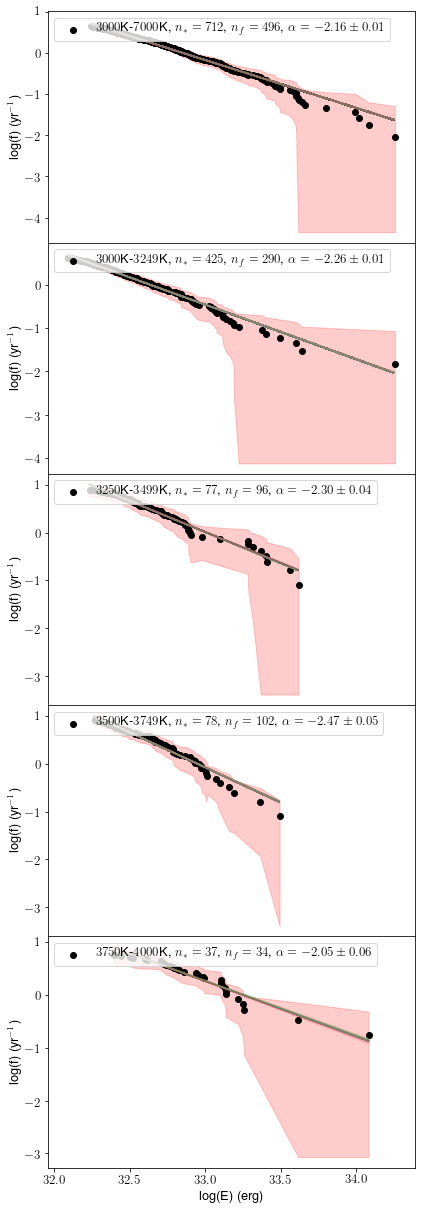

In [28]:
header = ['Tmin','Tmax','alpha','beta','alpha_err',
          'beta_err','minenerg','maxenerg','n_obj','nflares',
          'corrected']

specs2 = specs[specs.todrop == False]
axs = tuple(['ax{}'.format(i) for i in range(5)])
fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(nrows=5,ncols=1,figsize=(6.1,17),sharex=True)#8 5 

idx = 0
for (Tmin, Tmax, color, minenerg, maxenerg) in trange[cluster]:#fitset2[cluster][corr][:4]

    
    p, var, maxenerg, n_obj, n_flares = FFD_average(specs2, cluster, test, LCtype, color='k',
                                                    marker = 'o',axis=vars()[axs[idx]],
                                                    Tmin=Tmin, Tmax=Tmax, subset='temperature',
                                                    Minenerg=minenerg, Maxenerg=maxenerg,
                                                    fakes=True,onlyenergy=False,nobin=nobin)
    
 

    vars()[axs[idx]].set_xlabel('log(E) (erg)')
    vars()[axs[idx]].set_ylabel('log(f) (yr$^{-1}$)')

    #vars()[axs[idx]].set_ylim(-5.5,-2.8)
    #vars()[axs[idx]].set_xlim(32.,34)
    vars()[axs[idx]].legend(loc=2, fontsize='medium')
    idx+=1
    
plt.tick_params(axis = 'both', labelsize = 13)
plt.tight_layout()
plt.subplots_adjust(hspace=0)

3500.0 3749.0
Before removing high-energy artifacts: 56
After removing high-energy artifacts: 56
uncorrected  (56, 15)
True observation time: 18.1 years.
M44 observation duration in 3500.0-3749.0K bin is 0.05510218802181143.
(56, 9)
(56, 9)
Before removing high-energy artifacts: 56
After removing high-energy artifacts: 56
uncorrected  (56, 15)
True observation time: 18.1 years.
M44 observation duration in 3500.0-3749.0K bin is 0.05510218802181143.
(56, 9)
(56, 9)
Before removing high-energy artifacts: 56
After removing high-energy artifacts: 56
uncorrected  (47, 15)
True observation time: 18.1 years.
corrected  (30, 15)
M44 observation duration in 3500.0-3749.0K bin is 0.05510218802181143.
(30, 9)
(30, 9)


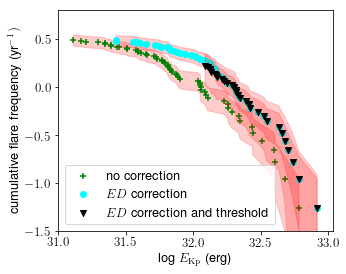

In [22]:
from matplotlib import rc, rcParams
rc('text', usetex=True)
rc('font', size=13)
rc('legend', fontsize=13)
rcParams.update({'font.size':13})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('mathtext', fontset='stixsans')

header = ['Tmin','Tmax','alpha','beta','alpha_err',
          'beta_err','minenerg','maxenerg','n_obj','nflares',
          'corrected']
results = pd.DataFrame(columns=header)
specs2 = specs[specs.todrop == False]
plt.figure(figsize=(5,4))#8 5 
for (Tmin, Tmax, color, minenerg, maxenerg) in trange[cluster][3:4]:#fitset2[cluster][corr][:4]:
    #plt.figure(figsize=(8,5))
    print(Tmin,Tmax)
    #plt.title('Cumulative FFD: {}'.format(cluster))
    
    
    FFD_average(specs2, cluster, test, LCtype, color='green',
                                                    marker = '+',
                                                    Tmin=Tmin, Tmax=Tmax, subset='temperature',
                                                    Minenerg=minenerg, Maxenerg=maxenerg,
                                                    fakes=False,onlyenergy=False, fitline=False)

    
    
    FFD_average(specs2, cluster, test, LCtype, color='cyan',
                                                     marker = 'o',
                                                     Tmin=Tmin, Tmax=Tmax, subset='temperature',
                                                     Minenerg=minenerg, Maxenerg=maxenerg,
                                                     fakes=True,onlyenergy=True, fitline=False)
    

    
    
    FFD_average(specs2, cluster, test, LCtype, color='k',
                                                    marker = 'v',
                                                    Tmin=Tmin, Tmax=Tmax, subset='temperature',
                                                    Minenerg=minenerg, Maxenerg=maxenerg,
                                                    fakes=True,onlyenergy=False, fitline=False)


    plt.ylabel('cumulative flare frequency (yr$^{-1})$')
    plt.tick_params(axis = 'both', labelsize = 13)

     
 
    plt.xlabel('log $E_\mathrm{Kp}$ (erg)')
    plt.legend()

    plt.ylim(-1.5,0.8)
    plt.tight_layout()
    plt.savefig('stars_shortlist/share/Paper/exmpFFD.png',dpi=300)


## DEPRECATED

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

# build a rectangle in axes coords
left, width = 0.35, .5
bottom, height = 0.4, .5
right = left + width
top = bottom + height
# ax = plt.gca()
# p = plt.Rectangle((left, bottom), width, height,
#               fill=False,
#               )



# ax.text(left, bottom, 'left top',
#         horizontalalignment='left',
#         verticalalignment='top',
#         transform=ax.transAxes)


def Teff_count(specs,cluster):
    specs['logL'] = np.log10(specs.L_quiet)
    
    plot = specs.plot(x='T',y='logL',
                      kind = 'scatter', 
                      color='black',
                      s=list(specs['counts']**2),
                      marker='o',
                      alpha=0.2,
                      title = '{}'.format(cluster),)
                      #figsize=(7,7))
    plot.set_ylabel('log(L_quiet)')
    plot.set_xlabel('T_eff')
    #plot.text(6.5, 6.5cm, r'1 flare', fontsize=11)
    plt.plot(5900, 30.82, 'o', markersize=25,color='black')
    fig = plot.get_figure()
    #fig.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/Teff_{}_counts.jpg'.format(cluster),dpi=300)
    return

def CMD_count(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(19,5),outliers=pd.Series()):
    '''
    Plots and saves CMDs for specified bands, 
    marks outliers if any are passed.
    '''
    #drops = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/Pleiades/redgiants.csv',
         #              header=None, names=['EPIC'])
    #print(drops.shape,specs.shape)
    #specs = specs.drop(drops.EPIC.tolist())
    #print(drops.shape,specs.shape)
    specs[color]=specs[cid1]-specs[cid2]
    plot = specs.plot(x=color,y=cid1,ylim=ylim,
                      kind = 'scatter', color='black',
                     # color=color_outlier_red(specs.index.values,drops.EPIC),
                      s=list(specs['counts']**2./2),
                      title = '{}'.format(cluster),
                      alpha=0.5,figsize=(6,5))
    
    
    plot.set_ylabel(cid1[0])
    plot.set_xlabel('{}-{}'.format(cid1[0],cid2[0]))
    plot.text(right, top, r'5 flares', transform=plot.transAxes, fontsize=11)
    plot.plot(right-.03, top+0.016, 'o', markersize=25/2,color='black', transform=plot.transAxes)

    fig = plot.get_figure()
    ax = plt.gca()
    plt.Rectangle((left, bottom), width, height,
              fill=False,
              )
    plt.set_transform(ax.transAxes)
    plt.set_clip_on(False)
    #ax.add_patch(p)

    #fig.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/CMD_{}_{}_counts.jpg'.format(cluster,color),dpi=300)
    return

# CMD_count(specs,cluster,cid1='gmag',cid2='zmag',color='g_z',ylim=(16,9))
#CMD_count(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(16,9))
#CMD_count(specs,cluster,cid1='J',cid2='K',color='J_K',ylim=(13,4))
# CMD_count(specs,cluster,cid1='rmag',cid2='zmag',color='r_z',ylim=(14.5,8))#,text=(16.5))
Teff_count(specs,cluster)

specs2 = specs.drop(overlap)
print(specs2[(specs2['T']>=3000.) & (specs2['T']<=7000.)].dur.sum()/24/365)
print(specs2[(specs2['T']>=3000.) & (specs2['T']<=3249.)].dur.sum()/24/365)
print(specs2[(specs2['T']>=3250.) & (specs2['T']<=3499.)].dur.sum()/24/365)
print(specs2[(specs2['T']>=3500.) & (specs2['T']<=3749.)].dur.sum()/24/365)
print(specs2[(specs2['T']>=3750.) & (specs2['T']<=4000.)].dur.sum()/24/365)